# Lecture 2
Connor Blake
3/26/25

In [1]:
import jax.numpy as jnp
import jax.random as jr
import jax
import matplotlib.pyplot as plt
import sklearn

In [2]:
jkey = jr.PRNGKey(seed=1)
jkey2 = jr.PRNGKey(seed=2)
jkey3 = jr.PRNGKey(seed=3)
jkey4 = jr.PRNGKey(seed=4)
N = 20
Ntest = 100
x = jr.uniform(jkey3,(N,))
xtest = jr.uniform(jkey4,(Ntest,))

xdense = jnp.linspace(0,1,200)
def f(x):
    return jnp.sin(jnp.pi*3.5*x)
yep = f(x)+.2*jr.normal(jkey,(N,))
ytest = f(xtest)+.2*jr.normal(jkey2,(Ntest,))

In [3]:
def polynomial_fit(x,data,order=4):
    X = jnp.column_stack(tuple([x**i for i in range(1,order+1)]))
    beta = jnp.linalg.inv(X.T@X)@X.T@data # exact basis formula minimizing L2
    return beta

def l2_polynomial_fit(x,data,order=4,param=10):
    X = jnp.column_stack(tuple([x**i for i in range(1,order+1)]))
    beta = jnp.linalg.inv(param*jnp.eye(X.shape[1])+X.T@X)@X.T@data
    return beta

def polynomial_predict(betas,xgrid):
    X = jnp.column_stack(tuple([xgrid**i for i in range(1,betas.shape[0]+1)]))
    return X@betas

def sine_fit(x,data,modes=4):
    X = jnp.column_stack(tuple([jnp.sin(n*jnp.pi*x) for n in range(1,modes+1)]))
    beta = jnp.linalg.inv(X.T@X)@X.T@data # exact basis formula minimizing L2
    return beta

def sine_predict(betas,xgrid):
    X = jnp.column_stack(tuple([jnp.sin(n*jnp.pi*xgrid) for n in range(1,betas.shape[0]+1)]))
    return X@betas

def RMS_loss(pred,actual):
    return jnp.sqrt(jnp.sum((pred-actual)**2)/pred.shape[0])

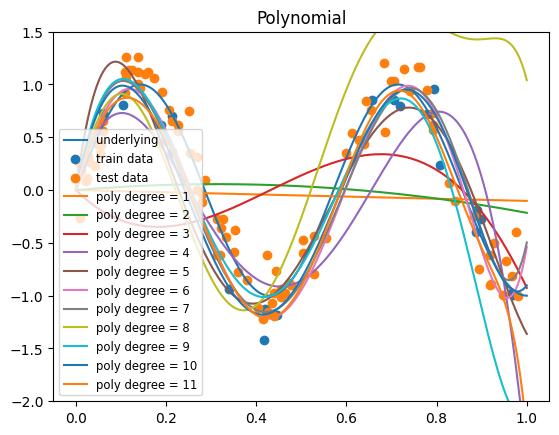

Text(0, 0.5, 'RMS Loss')

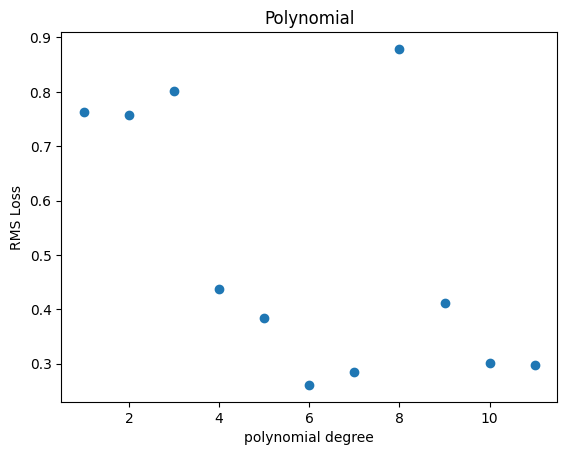

In [4]:
plt.plot(xdense,f(xdense),label="underlying")
plt.scatter(x,yep,label="train data")
plt.scatter(xtest,ytest,label="test data")
losses = []
for degree in range(1,12):
    betas_degree = polynomial_fit(x,yep,degree)
    ypred = polynomial_predict(betas_degree,xdense)
    plt.plot(xdense,ypred,label=f"poly degree = {degree}")
    losses.append((degree,RMS_loss(polynomial_predict(betas_degree,xtest),ytest)))
plt.title("Polynomial")
plt.legend(fontsize="small")
plt.ylim([-2,1.5])
plt.show()

losses = jnp.array(losses)
plt.title("Polynomial")
plt.scatter(losses[:,0],losses[:,1])
plt.xlabel("polynomial degree")
plt.ylabel("RMS Loss")

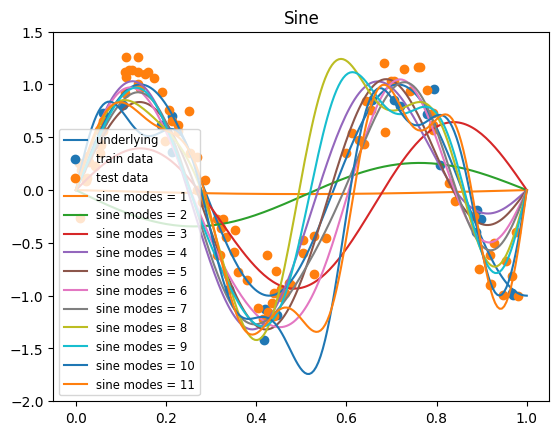

Text(0, 0.5, 'RMS Loss')

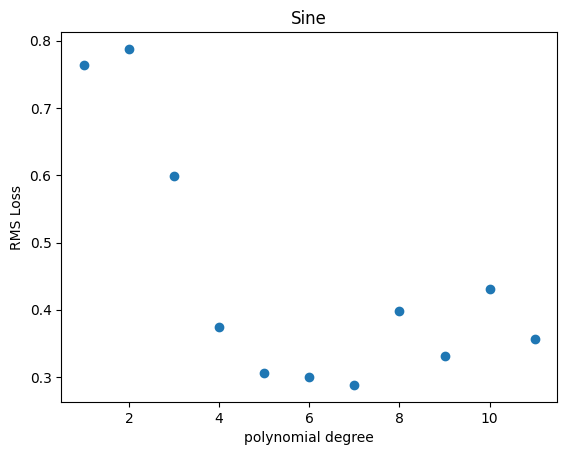

In [5]:
plt.plot(xdense,f(xdense),label="underlying")
plt.scatter(x,yep,label="train data")
plt.scatter(xtest,ytest,label="test data")
losses = []
for degree in range(1,12):
    betas_degree = sine_fit(x,yep,degree)
    ypred = sine_predict(betas_degree,xdense)
    plt.plot(xdense,ypred,label=f"sine modes = {degree}")
    losses.append((degree,RMS_loss(sine_predict(betas_degree,xtest),ytest)))
plt.title("Sine")
plt.legend(fontsize="small")
plt.ylim([-2,1.5])
plt.show()

losses = jnp.array(losses)
plt.title("Sine")
plt.scatter(losses[:,0],losses[:,1])
plt.xlabel("polynomial degree")
plt.ylabel("RMS Loss")

Comments:
- a fourier basis should be optimal for this data because it's a sine wave


## Regularization

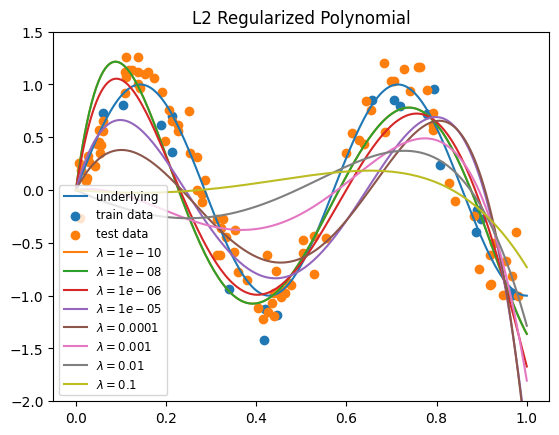

Text(0, 0.5, 'RMS Loss')

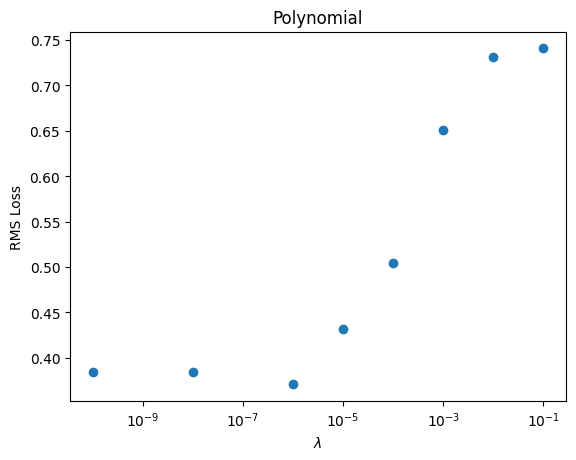

In [6]:
plt.plot(xdense,f(xdense),label="underlying")
plt.scatter(x,yep,label="train data")
plt.scatter(xtest,ytest,label="test data")
losses = []
for param in [1e-10,1e-8,1e-6,1e-5,.0001,.001,.01,.1]:
    betas_degree = l2_polynomial_fit(x,yep,5,param=param)
    ypred = polynomial_predict(betas_degree,xdense)
    plt.plot(xdense,ypred,label=fr"$\lambda= {param}$")
    losses.append((param,RMS_loss(polynomial_predict(betas_degree,xtest),ytest)))
plt.title("L2 Regularized Polynomial")
plt.legend(fontsize="small")
plt.ylim([-2,1.5])
plt.show()

losses = jnp.array(losses)
plt.title("Polynomial")
plt.scatter(losses[:,0],losses[:,1])
plt.xscale('log')
plt.xlabel(r"$\lambda$")
plt.ylabel("RMS Loss")

In [7]:
import sklearn.linear_model
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.237e-01, tolerance: 1.349e-03
  model = cd_fast.enet_coordinate_descent(
/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.401e-01, tolerance: 1.349e-03
  model = cd_fast.enet_coordinate_descent(
/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

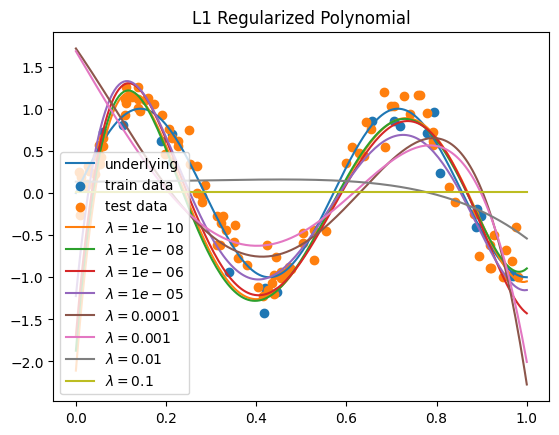

Text(0, 0.5, 'RMS Loss')

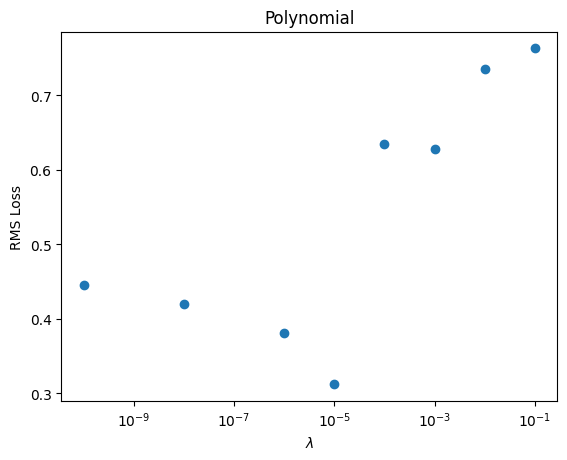

In [12]:

plt.plot(xdense,f(xdense),label="underlying")
plt.scatter(x,yep,label="train data")
plt.scatter(xtest,ytest,label="test data")
losses = []
for param in [1e-10,1e-8,1e-6,1e-5,.0001,.001,.01,.1]:
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=5)),  # polynomial expansion
        ("lasso", Lasso(alpha=param,max_iter=10000000))
    ])
    model.fit(x.reshape(-1, 1), yep)
    ytestpred = model.predict(xtest.reshape(-1,1))
    ydense = model.predict(xdense.reshape(-1,1))
    plt.plot(xdense,ydense,label=fr"$\lambda= {param}$")
    losses.append((param,RMS_loss(ytestpred,ytest)))
plt.legend()
plt.title("L1 Regularized Polynomial")
plt.show()

losses = jnp.array(losses)
plt.title("Polynomial")
plt.scatter(losses[:,0],losses[:,1])
plt.xscale('log')
plt.xlabel(r"$\lambda$")
plt.ylabel("RMS Loss")

L1 is better at sparse models and feature selection / interpretability but L2 is better for accuracy and stability